## Configure Defaults

In [1]:
import os

DATA_DIR = 'data/'
if not os.path.exists(DATA_DIR):
    os.mkdir(DATA_DIR)
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)

MODEL_TORCH = MODELS_DIR + 'model_torch.pth'
MODEL_TORCH_CKPT = MODELS_DIR + 'model_torch.ckpt'
MODEL_ONNX = MODELS_DIR + 'model.onnx'
MODEL_TF = MODELS_DIR + 'model'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_QUANT = MODELS_DIR + 'model_quant.tflite'
MODEL_TFLM = MODELS_DIR + 'image_recognition_model.cc'

## Import Dependencies

In [2]:
import sys
import time
import copy
import random

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.utils.prune as prune
from torch.utils.data import Subset, DataLoader

import torchvision
import torchvision.transforms as transforms
torch.cuda.is_available()

True

In [5]:
%env TF_CPP_MIN_LOG_LEVEL=3
import tensorflow as tf

env: TF_CPP_MIN_LOG_LEVEL=3


In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    %env CUBLAS_WORKSPACE_CONFIG=:4096:8
    cudnn.deterministic = True
    os.unsetenv('CUDA_VISIBLE_DEVICES')
    torch.cuda.device_count.cache_clear()
    torch.cuda.device_count()

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [7]:
import onnx
import onnx2tf

## Dataset

In [8]:
trainset = torchvision.datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=transforms.Compose([
    transforms.RandomCrop(32, padding=4, padding_mode='edge'),
    transforms.RandomHorizontalFlip(),
    transforms.PILToTensor(),
    lambda image: image.to(torch.float)-128
]))

validateset = torchvision.datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=transforms.Compose([
    transforms.PILToTensor(),
    lambda image: image.to(torch.float)-128
]))

def seed_worker(worker_id):
    np.random.seed(torch.initial_seed() % 2**32)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
testset = torchvision.datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=transforms.Compose([
    transforms.PILToTensor(),
    lambda image: image.to(torch.float)-128
]))

x_test, y_test = testset.data[0:350].astype('float32')-128, testset.targets[0:350]

Files already downloaded and verified


## Utility

In [10]:
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = len(train_loader.dataset)
    total_curr = 0
    begin_time = time.time()
    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total_curr += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        sys.stdout.write('Epoch %3d:' % (epoch+1))
        sys.stdout.write(' Loss: %.6f' % (train_loss/total_curr))
        sys.stdout.write(' | Acc: %3.3f%% (%5d/%5d)' % (100.*correct/total_curr, correct, total_curr))
        sys.stdout.write(' | %3d%%' % (100.*total_curr/total))
        if batch_idx < len(train_loader)-1:
            sys.stdout.write('\r')
    sys.stdout.write(' | Total: %d s\n' % (time.time() - begin_time))
    return train_loss/total, correct/total

In [11]:
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = len(test_loader.dataset)
    total_curr = 0
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(test_loader):
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total_curr += targets.size(0)
            correct += predicted.eq(targets.view_as(predicted)).sum().item()

            sys.stdout.write('Test     :')
            sys.stdout.write(' Loss: %.6f' % (test_loss/total_curr))
            sys.stdout.write(' | Acc: %3.3f%% (%5d/%5d)' % (100.*correct/total_curr, correct, total_curr))
            if batch_idx < len(test_loader)-1:
                sys.stdout.write('\r')
    sys.stdout.write('\n')
    return test_loss/total, correct/total

## Training

### Design the Model
```https://github.com/ShowLo/MobileNetV3/blob/master/mobileNetV3.py```

In [12]:
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.use_deterministic_algorithms(True)

In [13]:
class SEModule(nn.Module):
    def __init__(self, in_planes):
        super(SEModule, self).__init__()

        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.linear1 = nn.Linear(in_planes, in_planes // 4, bias=False)
        self.act1 = nn.ReLU(inplace=True)
        self.linear2 = nn.Linear(in_planes // 4, in_planes, bias=False)
        self.act2 = nn.Hardsigmoid(inplace=True)

    def forward(self, x):
        batch_size, channel_num, _, _ = x.size()
        y = self.avg_pool(x).view(batch_size, channel_num)
        y = self.act1(self.linear1(y))
        y = self.act2(self.linear2(y))
        y = y.view(batch_size, channel_num, 1, 1)
        return x * y

class Bottleneck(nn.Module):
    def __init__(self, in_planes, out_planes, expansion, kernel_size, stride, use_SE, use_HS):
        super(Bottleneck, self).__init__()

        self.use_expansion = (in_planes != expansion)
        self.use_SE = use_SE
        self.use_residual = (stride == 1 and in_planes == out_planes)

        if self.use_expansion:
            self.conv1 = nn.Conv2d(in_planes, expansion, kernel_size=1, stride=1, padding=0, bias=False)
            self.bn1 = nn.BatchNorm2d(expansion)
            self.act1 = nn.Hardswish(inplace=True) if use_HS else nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(expansion, expansion, kernel_size=kernel_size, stride=stride, padding=(kernel_size-1)//2, groups=expansion, bias=False)
        self.bn2 = nn.BatchNorm2d(expansion)
        if self.use_SE:
            self.se2 =  SEModule(expansion)
        self.act2 = nn.Hardswish(inplace=True) if use_HS else nn.ReLU(inplace=True)

        self.conv3 = nn.Conv2d(expansion, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = self.act1(self.bn1(self.conv1(x))) if self.use_expansion else x
        out = self.act2(self.se2(self.bn2(self.conv2(out)))) if self.use_SE else self.act2(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        if self.use_residual:
            out = out + x
        return out

class MobileNetV3(nn.Module):
    cfg = [
        [3, 16, 16, False, False, 1],
        [3, 32, 24, False, False, 2],
        [3, 48, 24, False, False, 1],
        [3, 64, 40, False, False, 2],
        [3, 120, 40, False, False, 1],
        [3, 120, 48, False, False, 1],
        [3, 144, 48, False, False, 1],
        [3, 288, 96, False, False, 2],
    ]

    def __init__(self):
        super(MobileNetV3, self).__init__()

        in_planes = 16
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, in_planes, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(in_planes),
            nn.ReLU(inplace=True)
        )

        for idx, (kernel_size, expansion, out_planes, use_SE, use_HS, stride) in enumerate(self.cfg):
            setattr(self, 'layer{}'.format(idx+2), Bottleneck(in_planes, out_planes, expansion, kernel_size, stride, use_SE, use_HS))
            in_planes = out_planes

        expansion = 288
        self.layer10 = nn.Sequential(
            nn.Conv2d(in_planes, expansion, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(expansion),
            nn.ReLU(inplace=True)
        )

        self.layer11 = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(expansion, 144, kernel_size=1, stride=1, padding=0, bias=False),
            nn.ReLU(inplace=True)
        )

        self.linear = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(144, 10)
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.layer1(x)
        for idx in range(2, 11+1):
            out = getattr(self, 'layer{}'.format(idx))(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

model = MobileNetV3()

### Resume from the Checkpoint

In [14]:
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.use_deterministic_algorithms(True)

In [15]:
total_epochs, folds = 200, 10
fold_images, fold_epochs = 50000 // folds, total_epochs // folds

In [16]:
criterion = nn.CrossEntropyLoss()

[SGDR: Stochastic Gradient Descent with Warm Restarts](https://arxiv.org/pdf/1608.03983.pdf)

In [17]:
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=4, verbose=True)
#scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=total_epochs, T_mult=1, eta_min=0, last_epoch=-1)

In [18]:
if os.path.isfile(MODEL_TORCH):
    model = torch.load(MODEL_TORCH)

if os.path.isfile(MODEL_TORCH_CKPT):
    checkpoint = torch.load(MODEL_TORCH_CKPT)
    optimizer.load_state_dict(checkpoint['optimizer'])
    scheduler.load_state_dict(checkpoint['scheduler'])
    epoch = start_epoch = checkpoint['epoch']
else:
    epoch = start_epoch = 0

### Train the Model

In [19]:
model = model.to(device)
if device == 'cuda' and not isinstance(model, nn.DataParallel):
    model = nn.DataParallel(model)

In [20]:
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.use_deterministic_algorithms(True)

In [21]:
class history_model: pass
history = tf.keras.callbacks.History()
history.set_model(history_model)

history.on_train_begin()
for epoch in range(start_epoch, start_epoch+total_epochs):
    k = (epoch // fold_epochs) // folds
    if epoch % fold_epochs == 0:
        train_gen = torch.Generator()
        train_gen.manual_seed(1)

        train_loader = DataLoader(
            Subset(trainset, [*range(0, k*fold_images), *range((k+1)*fold_images, 50000)]),
            batch_size=128,
            shuffle=True,
            num_workers=6,
            worker_init_fn=seed_worker,
            pin_memory=True,
            generator=train_gen
        )
        validate_loader = DataLoader(
            Subset(validateset, range(k*fold_images, (k+1)*fold_images)),
            batch_size=128,
            num_workers=6,
            pin_memory=True
        )
        test_loader = DataLoader(Subset(testset, range(0, 350)), batch_size=50, num_workers=6, pin_memory=True)

    l1, a1 = train(model, device, train_loader, optimizer, criterion, epoch)
    l2, a2 = test(model, device, validate_loader, criterion)
    scheduler.step(l1)
    history.on_epoch_end(epoch, logs={
        'loss': l1,
        'accuracy': a1,
        'val_loss': l2,
        'val_accuracy': a2
    })
    if (a2 <= np.array(history.history['val_accuracy'])).sum() <= 1:
        torch.save(model.module, MODELS_DIR + f'model_torch_{epoch+1}.pth')
        torch.save(model.module, MODEL_TORCH)

Epoch   1: Loss: 0.013165 | Acc: 37.220% (16749/45000) | 100% | Total: 9 s
Test     : Loss: 0.011165 | Acc: 48.360% ( 2418/ 5000)
Epoch   2: Loss: 0.009997 | Acc: 54.073% (24333/45000) | 100% | Total: 7 s
Test     : Loss: 0.009457 | Acc: 57.740% ( 2887/ 5000)
Epoch   3: Loss: 0.008275 | Acc: 62.769% (28246/45000) | 100% | Total: 7 s
Test     : Loss: 0.008112 | Acc: 64.340% ( 3217/ 5000)
Epoch   4: Loss: 0.007114 | Acc: 68.324% (30746/45000) | 100% | Total: 8 s
Test     : Loss: 0.007949 | Acc: 66.740% ( 3337/ 5000)
Epoch   5: Loss: 0.006431 | Acc: 71.376% (32119/45000) | 100% | Total: 7 s
Test     : Loss: 0.006042 | Acc: 73.360% ( 3668/ 5000)
Epoch   6: Loss: 0.006056 | Acc: 73.158% (32921/45000) | 100% | Total: 8 s
Test     : Loss: 0.007326 | Acc: 68.840% ( 3442/ 5000)
Epoch   7: Loss: 0.005619 | Acc: 75.251% (33863/45000) | 100% | Total: 7 s
Test     : Loss: 0.006148 | Acc: 73.480% ( 3674/ 5000)
Epoch   8: Loss: 0.005386 | Acc: 76.456% (34405/45000) | 100% | Total: 8 s
Test     : Loss

In [22]:
if device == 'cuda' and isinstance(model, nn.DataParallel):
    model = model.module
model = model.to('cpu')

In [23]:
torch.save(model, MODEL_TORCH)

### Plot Metrics

**Loss**

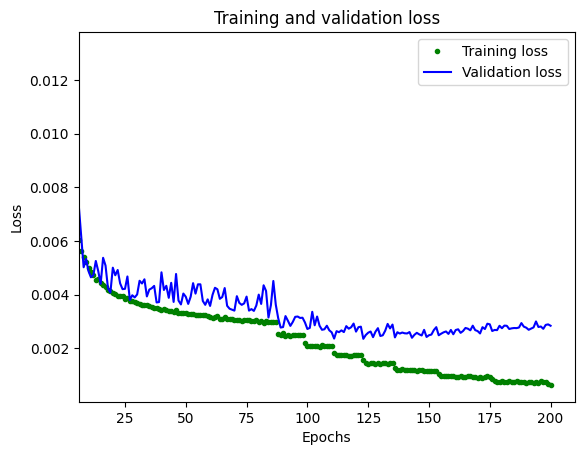

In [24]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.xlim(left=6)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Accuracy**

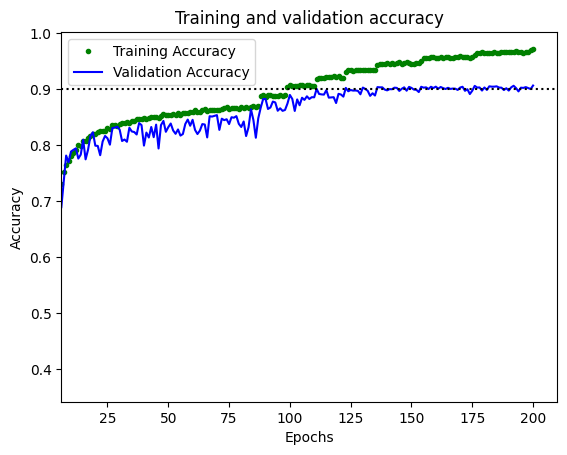

In [25]:
plt.clf()

# Draw a graph of accuracy, which is another way of measuring the amount
# of error in the prediction.
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, train_acc, 'g.', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.axhline(y=0.9, c='k', ls=':')
plt.xlim(left=6)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Generate a TensorFlow Lite Model

### Check PyTorch Accuracy

In [26]:
model_torch = torch.load(MODELS_DIR + 'model_torch.pth')
if device == 'cuda' and isinstance(model_torch, nn.DataParallel):
    model_torch = model_torch.module
model_torch = model_torch.to('cpu')
test_loader = DataLoader(Subset(testset, range(0, 350)), batch_size=50, num_workers=6, pin_memory=True)
_, _ = test(model_torch, 'cpu', test_loader, nn.CrossEntropyLoss())

Test     : Loss: 0.005130 | Acc: 90.857% (  318/  350)


### PyTorch to ONNX

In [27]:
dummy_input = torch.zeros(1, 3, 32, 32)
torch.onnx.export(
    model_torch, 
    dummy_input, 
    MODEL_ONNX,
    verbose=False,
    input_names=['input'],
    output_names=['output'],
    opset_version=14
)

### ONNX to TensorFlow

~~Insert a `Transpose` node after the input to keep the input shape in NCHW.~~

`void reshape_cifar_image(uint8_t*, int8_t*)` already did the transpose on board.

In [28]:
model_onnx = onnx.load(MODEL_ONNX)
model_onnx = onnx.shape_inference.infer_shapes(model_onnx, check_type=True, strict_mode=True, data_prop=True)
onnx.checker.check_model(model_onnx)

In [29]:
onnx_operations = []
for node in filter(lambda node: node.op_type in ['Mul', 'Add'], model_onnx.graph.node):
    onnx_operations.append({
        'op_name': node.name,
        'param_target': 'inputs',
        'param_name': node.input[1],
        'pre_process_transpose_perm': [0, 2, 3, 1]
    })

import json
with open(MODELS_DIR + 'param_replacement.json', 'w') as f:
    f.write(json.dumps({'format_version': 1, 'operations': onnx_operations}, indent=2))

In [30]:
model_tf_rep = onnx2tf.convert(
    input_onnx_file_path=MODEL_ONNX,
    onnx_graph=model_onnx,
    output_folder_path=MODEL_TF,
    output_signaturedefs=True,
    output_h5=False,
    output_integer_quantized_tflite=False,
    not_use_onnxsim=False,
    replace_hardswish_to_pseudo_hardswish=False,
    param_replacement_file=MODELS_DIR + 'param_replacement.json',
    non_verbose=True
)

### TensorFlow to TFLite

In [31]:
model_tf = tf.saved_model.load(MODEL_TF)

In [32]:
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)
converter.exclude_conversion_metadata = True
model_tflite = converter.convert()
len(model_tflite)

671876

### TFLite Quantization

In [33]:
seed = 1
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [34]:
compute_encoding_set = torchvision.datasets.CIFAR10(root=DATA_DIR, train=True, download=True).data[0:50000].astype('float32')-128
print(compute_encoding_set.shape)

Files already downloaded and verified
(50000, 32, 32, 3)


In [35]:
def representative_dataset():
    for i in range(1000):
        yield([compute_encoding_set[i].reshape(1, 32, 32, 3)])

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
model_tflite_quant = converter.convert()
len(model_tflite_quant)

fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


247120

### Metadata Trimming
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/schema/schema.fbs

In [36]:
import flatbuffers
from tensorflow.lite.python import schema_py_generated as schema
#from tensorflow.lite.tools.flatbuffer_utils import read_model

def tflm_trim(model: bytearray):
    Model = schema.Model.GetRootAs(bytearray(model), 0)
    ModelT = schema.ModelT.InitFromObj(Model)
    builtin_operators = [(OperatorCodeT.customCode or OperatorCodeT.builtinCode, OperatorCodeT.version) for OperatorCodeT in ModelT.operatorCodes]
    for SubGraphT in ModelT.subgraphs:
        for TensorT in SubGraphT.tensors:
            TensorT.type
            TensorT.buffer
            TensorT.name = ''
            TensorT.quantization.scale
            TensorT.quantization.zeroPoint
            TensorT.quantization.quantizedDimension
        SubGraphT.name = ''
        subgraph_operators = [builtin_operators[OperatorT.opcodeIndex][0] for OperatorT in SubGraphT.operators]
    ModelT.description = ''
    for MetadataT in filter(lambda x: x.name.decode() == 'min_runtime_version', ModelT.metadata):
        min_runtime_version = bytearray(ModelT.buffers[MetadataT.buffer].data).decode().rstrip('\x00')
    ModelT.signatureDefs = None
    builder = flatbuffers.Builder(0)
    builder.Finish(ModelT.Pack(builder), file_identifier='TFL3'.encode())
    return bytes(builder.Output())

In [37]:
model_tflite = tflm_trim(model_tflite)
open(MODEL_TFLITE, 'wb').write(model_tflite)

666332

In [38]:
model_tflite_quant = tflm_trim(model_tflite_quant)
open(MODEL_TFLITE_QUANT, "wb").write(model_tflite_quant)

241560

In [39]:
tf.lite.experimental.Analyzer.analyze(model_content=model_tflite_quant)

=== TFLite ModelAnalyzer ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the CONV_2D op takes
tensor #0 and tensor #56 and tensor #55 as input and produces tensor #57 as output.

Subgraph#0 (T#0) -> [T#91]
  Op#0 CONV_2D(T#0, T#56, T#55[8489, 20581, 12052, 21102, 19546, ...]) -> [T#57]
  Op#1 DEPTHWISE_CONV_2D(T#57, T#54, T#53[-2859, 4051, 1219, 2009, 1525, ...]) -> [T#58]
  Op#2 CONV_2D(T#58, T#52, T#51[5787, -4538, -1274, -6288, -2669, ...]) -> [T#59]
  Op#3 ADD(T#59, T#57) -> [T#60]
  Op#4 CONV_2D(T#60, T#50, T#49[9205, 7701, 1124, 6191, -89, ...]) -> [T#61]
  Op#5 PAD(T#61, T#1[0, 0, 1, 1, 1, ...]) -> [T#62]
  Op#6 DEPTHWISE_CONV_2D(T#62, T#48, T#47[-254, -20, -1834, -245, 276, ...]) -> [T#63]
  Op#7 CONV_2D(T#63, T#46, T#45[-3193, -1886, -9591, 1188, -2286, ...]) -> [T#64]
  Op#8 CONV_2D(T#64, T#44, T#43[5360, 4069, 5017, 5973, 16156, ...]) -> [T#65]
  Op#9 DEPTHWISE_CONV_2D(T#65, T#42, T#

## Compare Model Performance

In [40]:
def predict_tf(tf_model, x_test):
    _output = tf.zeros([0, 10], dtype='float32')
    for data in x_test:
        __output = tf_model(**{'inputs': tf.convert_to_tensor([data], dtype='float32')})[0]
        _output = tf.concat([_output, [__output]], 0)
    return _output.numpy()

def predict_tflite(tflite_model, x_test):
    x_test_ = x_test.copy()
    x_test_ = x_test_.astype(np.float32)

    interpreter = tf.lite.Interpreter(model_content=tflite_model)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    input_scale, input_zero_point = input_details["quantization"]
    if (input_scale, input_zero_point) != (0.0, 0):
        #print(input_scale, input_zero_point)
        x_test_ = x_test_ / input_scale + input_zero_point
        x_test_ = x_test_.astype(input_details["dtype"])

    y_pred = np.empty((x_test_.shape[0], output_details["shape"][1]), dtype=output_details["dtype"])
    for i in range(len(x_test_)):
        interpreter.set_tensor(input_details["index"], [x_test_[i]])
        interpreter.invoke()
        y_pred[i] = interpreter.get_tensor(output_details["index"])[0]

    output_scale, output_zero_point = output_details["quantization"]
    if (output_scale, output_zero_point) != (0.0, 0):
        #print(output_scale, output_zero_point)
        y_pred = y_pred.astype(np.float32)
        y_pred = (y_pred - output_zero_point) * output_scale

    return y_pred

def evaluate_tflite_softmax(y_pred, y_true):
    y_pred_softmax = tf.keras.activations.softmax(tf.convert_to_tensor(y_pred), axis=1)
    loss_function = tf.keras.losses.CategoricalCrossentropy()
    loss = loss_function(y_true, y_pred_softmax).numpy()
    return np.average(loss)

def confusion_matrix(y_true, y_pred, subplot):
    assert(len(y_true) == len(y_pred))
    conf = np.zeros((10, 10), dtype='int')
    for x, y in zip(y_true, y_pred):
        conf[x][y] += 1
    subplot.imshow(conf)
    for x in range(10):
        for y in range(10):
            subplot.annotate(str(conf[x][y]), xy=(y, x), horizontalalignment='center', verticalalignment='center')

**Predictions**

In [41]:
y_pred_tf = predict_tf(model_tf, x_test)
y_pred_tflite = predict_tflite(model_tflite, x_test)
y_pred_tflite_quant = predict_tflite(model_tflite_quant, x_test)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [42]:
print(y_pred_tf[0:1])
print(y_pred_tflite[0:1])
print(y_pred_tflite_quant[0:1])

[[-4.5133424 -2.5515444  0.9526232 14.441479  -1.5507847  5.9530787
   0.6182363 -3.4118662 -3.5918121 -6.3472466]]
[[-4.513341   -2.5515444   0.9526235  14.441473   -1.5507826   5.953078
   0.61823285 -3.4118626  -3.5918102  -6.3472476 ]]
[[-4.565719   -2.7791333   0.99254763 14.491196   -1.3895667   6.1537952
   0.5955286  -3.5731716  -3.5731716  -6.352305  ]]


In [43]:
correct_tf = (y_test == np.argmax(y_pred_tf, axis=1))
correct_tflite = (y_test == np.argmax(y_pred_tflite, axis=1))
correct_tflite_quant = (y_test == np.argmax(y_pred_tflite_quant, axis=1))

num_tf = correct_tf[0:350].sum() + correct_tf[50:300].sum()
num_tflite = correct_tflite[0:350].sum() + correct_tflite[50:300].sum()
num_tflite_quant = correct_tflite_quant[0:350].sum() + correct_tflite_quant[50:300].sum()

print("Predicted {} correct out of {}; Accuracy = {:.3f}".format(num_tf, 600, num_tf / 600))
print("Predicted {} correct out of {}; Accuracy = {:.3f}".format(num_tflite, 600, num_tflite / 600))
print("Predicted {} correct out of {}; Accuracy = {:.3f}".format(num_tflite_quant, 600, num_tflite_quant / 600))

Predicted 543 correct out of 600; Accuracy = 0.905
Predicted 543 correct out of 600; Accuracy = 0.905
Predicted 546 correct out of 600; Accuracy = 0.910


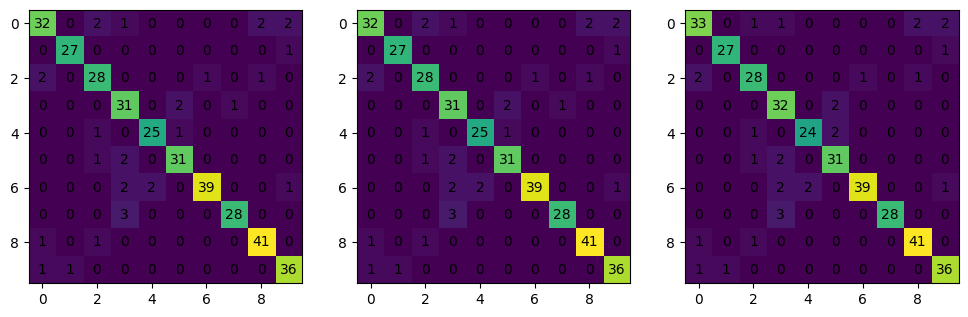

In [44]:
fig = plt.figure(figsize=(12, 8))
confusion_matrix(y_test, np.argmax(y_pred_tf, axis=1), fig.add_subplot(1,3,1))
confusion_matrix(y_test, np.argmax(y_pred_tflite, axis=1), fig.add_subplot(1,3,2))
confusion_matrix(y_test, np.argmax(y_pred_tflite_quant, axis=1), fig.add_subplot(1,3,3))

**Loss**

In [45]:
loss_tf = evaluate_tflite_softmax(y_pred_tf, tf.one_hot(y_test, 10))
loss_tflite = evaluate_tflite_softmax(y_pred_tflite, tf.one_hot(y_test, 10))
loss_tflite_quant = evaluate_tflite_softmax(y_pred_tflite_quant, tf.one_hot(y_test, 10))

In [46]:
df = pd.DataFrame.from_records(
    [["TensorFlow", loss_tf],
     ["TensorFlow Lite", loss_tflite],
     ["TensorFlow Lite Quantized", loss_tflite_quant]],
     columns = ["Model", "Loss/CE"], index="Model").round(4)
df

,Loss/CE
Model,
TensorFlow,0.2565
TensorFlow Lite,0.2565
TensorFlow Lite Quantized,0.2680


**Size**

In [47]:
size_tf = os.path.getsize(MODEL_TF + '/saved_model.pb')
size_tflite = os.path.getsize(MODEL_TFLITE)
size_tflite_quant = os.path.getsize(MODEL_TFLITE_QUANT)

In [48]:
pd.DataFrame.from_records(
    [["TensorFlow", f"{size_tf} bytes", ""],
     ["TensorFlow Lite", f"{size_tflite} bytes ", f"(reduced by {size_tf - size_tflite} bytes)"],
     ["TensorFlow Lite Quantized", f"{size_tflite_quant} bytes", f"(reduced by {size_tflite - size_tflite_quant} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")

,Size,
Model,,
TensorFlow,4598302 bytes,
TensorFlow Lite,666332 bytes,(reduced by 3931970 bytes)
TensorFlow Lite Quantized,241560 bytes,(reduced by 424772 bytes)


## Generate a TensorFlow Lite for Microcontrollers Model

In [49]:
!xxd -i {MODEL_TFLITE_QUANT} > {MODEL_TFLM}
REPLACE_TEXT = MODEL_TFLITE_QUANT.replace('/', '_').replace('.', '_').replace('-', '_')
!sed -i 's/'{REPLACE_TEXT}'/image_recognition_model_data/g' {MODEL_TFLM}

In [50]:
!sed -i '1s|unsigned char |#include "image_recognition/image_recognition_model.h" \n\n// Keep model aligned to 8 bytes to guarantee aligned 64-bit accesses. \n\n__attribute__ ((section (".rodata")))\nalignas(8) const unsigned char |g' {MODEL_TFLM}
!sed -i '$s|unsigned int |unsigned const int |g' {MODEL_TFLM}